<a href="https://colab.research.google.com/github/Ratnesh0301/Face__recognition/blob/master/Park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip ParkingData.zip

In [0]:
#Import Resources

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import cv2
import torch.utils.data as utils
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim


In [0]:
DATADIR = "./ParkingData/Train/"
classes = ['busy','free']

In [0]:
training_data = []
IMG_SIZE = 224

def create_training_data():
  for category in classes:
    path = os.path.join(DATADIR,category) # path to busy & free
    class_num = classes.index(category)

    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        img_rgb = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
        training_data.append([img_rgb,class_num])
      except Exception as e:
        pass


create_training_data()

In [0]:
import random

random.shuffle(training_data)

X = []
Y = []

for feature, label in training_data:
  X.append(feature)
  Y.append(label)

X_train = np.array(X)
Y_train = np.array(Y)
print(X_train.shape)

(600, 224, 224, 3)


In [0]:
train = []

for i in range(X_train.shape[0]):
  train.append(X_train[i].transpose((2,1,0)))


In [0]:
train = np.array(train)
print(train.shape)

(600, 3, 224, 224)


In [0]:
tensor_x = torch.stack([torch.tensor(j) for j in train])
tensor_y = torch.stack([torch.tensor(j) for j in Y_train])
tensor_x = tensor_x.type('torch.FloatTensor')
tensor_y = tensor_y.type('torch.LongTensor')

In [0]:
batch_size = 4
num_classes = 2
dataset = utils.TensorDataset(tensor_x,tensor_y)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Dataset transformation and Visualization

In [0]:
num_classes = 2
batch_size = 4

trainloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
0


# VGG16

In [0]:
vgg = models.vgg16_bn()

print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
print(vgg.features[0])
print(vgg.classifier[6])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear(in_features=4096, out_features=1000, bias=True)


In [0]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=2, bias=True)]


In [0]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
def evaluation(dataloader,model):
  total, correct = 0,0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
    
  return 100 * correct/total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.001)

Iteration: 0/12500, Loss: 0.93
Iteration: 100/12500, Loss: nan
Epoch : 0/1. Train acc: 50.00


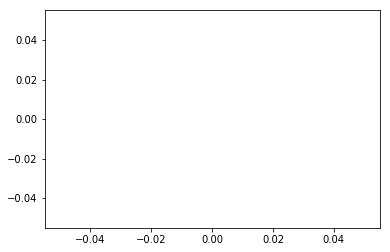

In [0]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  
  for i,data in enumerate(trainloader,0):
    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    opt.zero_grad
    
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
    if i%100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f'%(i, n_iters, loss.item()))
      
  loss_epoch_arr.append(loss.item())
  
  print('Epoch : %d/%d. Train acc: %0.2f'%(epoch,max_epochs,evaluation(trainloader,vgg)))
  
  
plt.plot(loss_epoch_arr)
plt.show()
